In [1]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import kapre
from kapre.composed import get_melspectrogram_layer
import tensorflow as tf
import os


def Conv1D(N_CLASSES=10, SR=16000, DT=1.0):
    input_shape = (int(SR*DT), 1)
    i = get_melspectrogram_layer(input_shape=input_shape,
                                 n_mels=128,
                                 pad_end=True,
                                 n_fft=512,
                                 win_length=400,
                                 hop_length=160,
                                 sample_rate=SR,
                                 return_decibel=True,
                                 input_data_format='channels_last',
                                 output_data_format='channels_last')
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = TimeDistributed(layers.Conv1D(8, kernel_size=(4), activation='tanh'), name='td_conv_1d_tanh')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_1')(x)
    x = TimeDistributed(layers.Conv1D(16, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_2')(x)
    x = TimeDistributed(layers.Conv1D(32, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_3')(x)
    x = TimeDistributed(layers.Conv1D(64, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_4')(x)
    x = TimeDistributed(layers.Conv1D(128, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_4')(x)
    x = layers.GlobalMaxPooling2D(name='global_max_pooling_2d')(x)
    x = layers.Dropout(rate=0.1, name='dropout')(x)
    x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='1d_convolution')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def Conv2D(N_CLASSES=10, SR=16000, DT=1.0):
    input_shape = (int(SR*DT), 1)
    i = get_melspectrogram_layer(input_shape=input_shape,
                                 n_mels=128,
                                 pad_end=True,
                                 n_fft=512,
                                 win_length=400,
                                 hop_length=160,
                                 sample_rate=SR,
                                 return_decibel=True,
                                 input_data_format='channels_last',
                                 output_data_format='channels_last')
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = layers.Conv2D(8, kernel_size=(7,7), activation='tanh', padding='same', name='conv2d_tanh')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_1')(x)
    x = layers.Conv2D(16, kernel_size=(5,5), activation='relu', padding='same', name='conv2d_relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_2')(x)
    x = layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_3')(x)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_4')(x)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_4')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='2d_convolution')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def LSTM(N_CLASSES=10, SR=16000, DT=1.0):
    input_shape = (int(SR*DT), 1)
    i = get_melspectrogram_layer(input_shape=input_shape,
                                     n_mels=128,
                                     pad_end=True,
                                     n_fft=512,
                                     win_length=400,
                                     hop_length=160,
                                     sample_rate=SR,
                                     return_decibel=True,
                                     input_data_format='channels_last',
                                     output_data_format='channels_last',
                                     name='2d_convolution')
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = TimeDistributed(layers.Reshape((-1,)), name='reshape')(x)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [2]:
pip install kapre

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


  Created wheel for kapre: filename=kapre-0.3.7-py3-none-any.whl size=29603 sha256=0f3839008c4cedecfbe4332959e4203e4ebc593300fb3db5dd5ad56a3a31310c
  Stored in directory: /Users/quanhongjin/Library/Caches/pip/wheels/d2/17/ce/09b7d799a7c8b463b0a1657941331e0f10112864ff78d28f87
Successfully built kapre
Note: you may need to restart the kernel to use updated packages.


  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/51/ee/0dc37001d5538a10482045b6796293f0c9c36eaa869c91f0b28a2c918a0f/aggdraw-1.3.18-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.4 MB/s eta 0:00:00m eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


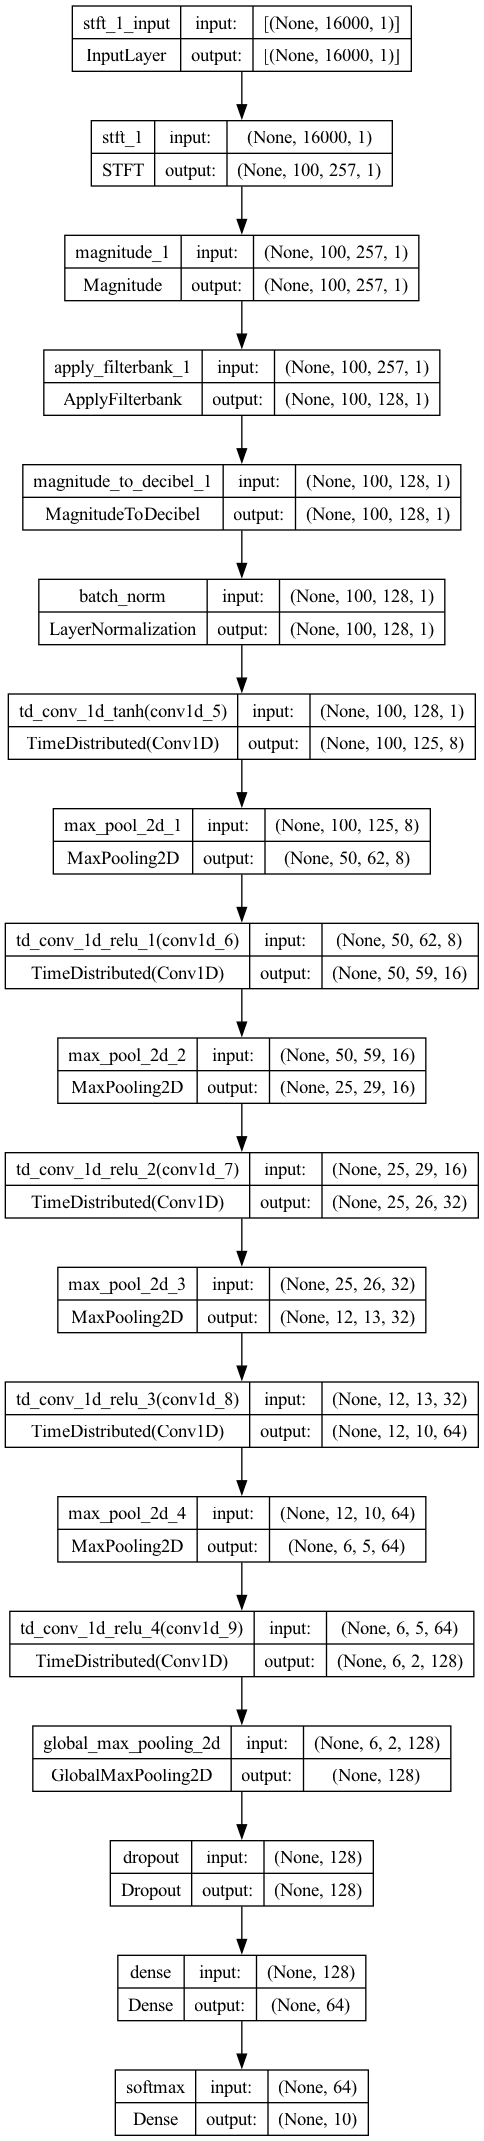

In [3]:
from tensorflow.keras.utils import plot_model

model = Conv1D()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.
